# Research Design Diagnosis Assignment Starting Point - Binary Outcomes
J. Nathan Matias ([natematias.com](https://natematias.com)) ([@natematias](https://twitter.com/natematias))
April 2019

Materials related to the Power Analysis Assignment in the 2019 edition of [SOC412](http://natematias.com/courses/soc412/).

In [11]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)           # contains fitdistr
library(ggplot2)        # for plotting 
library(rlang)
#library(logistf)        # contains Firth regression estimator (see King & Zeng) https://gking.harvard.edu/files/0s.pdf
library(tidyverse)
library(viridis)        # colorblind safe palettes
#library(gmodels)        # contains CrossTable
library(DeclareDesign)
library(beepr)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.3

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] beepr_1.3            DeclareDesign_0.13.0 estimatr_0.14       
 [4] fabricatr_0.6.0      randomizr_0.16.1     gmodels_2.18.1      
 [7] viridis_0.5.1        viridisLite_0.3.0    forcats_0.3.0       
[10] stringr_1.3.1        purrr_0.2.5          readr_1.3.1         
[13] tidyr_0.8.2          tibble_2.0.0         tidyverse_1.2.1     
[16] logistf_1.23         rlang_0.3.0.1        ggplot2_3.1.0       
[19] MASS_7.3-51.1        dplyr_0.7.8         

loaded via a namespace (and not attached):
 [1] 

### Utility Methods

In [2]:
# Return the difference in mu associated with an incidence rate ratio
# from a negative binomial model. This difference can then be used to
# simulate a negative binomial distribution for the effect of a given irr
#                                                                       
#` @param mu The baseline mu in question                               
#` @param irr The incidence rate ratio in question
mu.diff.from.mu.irr <- function(mu, irr){
    mu*(irr-1)
}

# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param p the probability in question
betas.logit.from.prob <- function(p){
    log(p/(1-p))
}


# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param Y list of observed Ys
betas.logit.from.mean <- function(Y){
    p = mean(Y)
    log(p/(1-p))
}

# Return the minimum power reported in a diagnosis
# 
#` @param diagnosis
min.diagnosis.power <- function(diagnosis){
    min(diagnosis$diagnosands_df['power'])
}

# Iterate linearly for a certain level of statistical power
# within the constraints of a configuration file
# at a certain sample size increment. Useful for
# illustrating ideas, or for comparing estimators with
# very different statistical power, where the binary search
# will optimize for the worst estimator but not show useful
# indormation about more efficient estimators
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @iteration.interval when iterating, use this interval between sample sizes

iterate.for.power <- function(config.df, diagnosis.method = diagnose.experiment, 
                             iteration.interval){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = min.sample.size
    
    iteration.count = ceiling((max.sample.size - min.sample.size) / iteration.interval)

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()

    ptm = proc.time()
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    
    for(i in seq(1, iteration.count)){
        current.sample.size = current.sample.size + iteration.interval
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()
    
        ptm = proc.time()
        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    }
    diagnoses.df
}

# Create a plot of a power search or iteration output
# And save to a file
# Especially useful in cases with multiple DVs or models
#
#` @param diagnoses Dataframe of diagnosis info
#` @param config.df the power analysis config dataframe

plot.power.results <- function(diagnoses, config.df){
    for(estimator_label in unique(diagnoses$estimator_label)){
        estimator.diagnoses <- diagnoses[diagnoses$estimator_label==estimator_label,]
        estimator_min_sample = min(estimator.diagnoses$n[estimator.diagnoses$power>0.8])
        p <- ggplot(data=estimator.diagnoses, aes(n, power)) +
                geom_point(color="coral") +
                xlab("sample size") +
                ylim(0,1) +
                geom_hline(aes(yintercept=0.8), linetype="dashed") +
                theme_light() +
                ggtitle(paste(config.df$pa.label, ": statistical Power for Estimator ", estimator_label, "\n",
                              "Minimum sample: ", estimator_min_sample, sep="")) +
                ggsave(paste("figures/power.analysis.", make.names(estimator_label), ".", config.df$pa.label, ".png", sep=""))
    }
}

### Experiment Configuration

In [3]:
example.config <- data.frame(
    pa.label = "example.design",
    n.max = 1230,
    n.min = 30,

    ACT.ctl      = 0.00,    ## the control group probability of taking an action 
    ACT.effect.a = 0.03,    ## the increase in the probability of taking action A
    ACT.effect.b = 0.06     ## the increase in the probability of taking action B
)

### Method for diagnosing an experiment

In [4]:
diagnose.experiment  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <-   declare_population(N = n.size) +
            declare_potential_outcomes(
                ACT_Z_0 = rbinom(N, 1, cdf$ACT.ctl),
                ACT_Z_1 = rbinom(N, 1, cdf$ACT.ctl + cdf$ACT.effect.a),
                ACT_Z_2 = rbinom(N, 1, cdf$ACT.ctl + cdf$ACT.effect.b)
            ) +
            declare_assignment(num_arms = 3,
                               conditions = c("0", "1", "2"),
                               assignment_variable = Z) +
        
            ## ESTIMANDS FOR LOGISTIC REGRESSION (PROPORTIONS / MEANS)
            declare_estimand(ate_ACT_mean_1_0  = cdf$ACT.effect.a) +
            declare_estimand(ate_ACT_mean_2_0  = cdf$ACT.effect.b) +
            declare_estimand(ate_ACT_mean_2_1  = cdf$ACT.effect.b - cdf$ACT.effect.a) +

            ## REVEAL
            declare_reveal(outcome_variables = c("ACT"), assignment_variables = c("Z")) +
            

            ##
            ## ESTIMATORS FOR ACT (OLS regression)
            ## The reason I have written these custom handlers is that DeclareDesign's
            ## difference in means estimator has problems with cases where there is no 
            ## difference at all, and where all outcome variables are zero. In that case
            ## I set the p value to 1 in order to successfully diagnose the design
            ## 
            declare_estimator(label = "ACT_na_handling_mean_1_0", estimand="ate_ACT_mean_1_0",
                              handler=tidy_estimator(function(data){
                                  m <- lm(formula= ACT ~ Z, data, subset = (Z %in% c(0,1)))

                                  out <- subset(tidy(m), term == "Z1")
                                  if(m$coefficients['Z1'] == 0){
                                      out$p.value = 1
                                  }                                  
                                  transform(out,
                                      conf.low = estimate - 1.96*std.error,
                                      conf.high = estimate + 1.96*std.error
                                  )
                              }))  +
            declare_estimator(label = "ACT_na_handling_mean_2_0", estimand="ate_ACT_mean_2_0",
                              handler=tidy_estimator(function(data){
                                  m <- lm(formula= ACT ~ Z, data, subset = (Z %in% c(0,2)))

                                  out <- subset(tidy(m), term == "Z2")
                                  if(m$coefficients['Z2'] == 0){
                                      out$p.value = 1
                                  }                                  
                                  transform(out,
                                      conf.low = estimate - 1.96*std.error,
                                      conf.high = estimate + 1.96*std.error
                                  )
                              }))  +
            declare_estimator(label = "ACT_na_handling_mean_2_1", estimand="ate_ACT_mean_2_1",
                              handler=tidy_estimator(function(data){
                                  m <- lm(formula= ACT ~ Z, data, subset = (Z %in% c(2,1)))

                                  out <- subset(tidy(m), term == "Z2")
                                  if(m$coefficients['Z2'] == 0){
                                      out$p.value = 1
                                  }                                  
                                  transform(out,
                                      conf.low = estimate - 1.96*std.error,
                                      conf.high = estimate + 1.96*std.error
                                  )
                              })) 

     diagnosis <- diagnose_design(design, sims = sims.count, 
                                  bootstrap_sims = bootstrap.sims.count)
     diagnosis
}

In [5]:
interval = 60
power.iterate.df <- iterate.for.power(example.config, 
                                      diagnosis.method=diagnose.experiment, 
                                      iteration.interval = interval)
beep(sound="treasure")

[1] "min: 30 max: 1230 current: 30"


Warning message:
“`quo_expr()` is soft-deprecated as of rlang 0.2.0.
Please use `quo_squash()` instead
This warning is displayed once per session.”Warning message:
“Assigning non-quosure objects to quosure lists is soft-deprecated.
Please coerce to a bare list beforehand with `as.list()`
This warning is displayed once per session.”Warning message:
“`is_lang()` is soft-deprecated as of rlang 0.2.0.
Please use `is_call()` instead
This warning is displayed once per session.”Warning message:
“`lang_name()` is soft-deprecated as of rlang 0.2.0.
Please use `call_name()` instead
This warning is displayed once per session.”

[1] "     seconds: 12"
[1] "min: 30 max: 1230 current: 90"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 150"
[1] "     seconds: 10"
[1] "min: 30 max: 1230 current: 210"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 270"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 330"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 390"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 450"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 510"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 570"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 630"
[1] "     seconds: 13"
[1] "min: 30 max: 1230 current: 690"
[1] "     seconds: 14"
[1] "min: 30 max: 1230 current: 750"
[1] "     seconds: 12"
[1] "min: 30 max: 1230 current: 810"
[1] "     seconds: 12"
[1] "min: 30 max: 1230 current: 870"
[1] "     seconds: 12"
[1] "min: 30 max: 1230 current: 930"
[1] "     seconds: 11"
[1] "min: 30 max: 1230 current: 990"
[1] "     seconds: 12"
[1] "min: 30 max: 

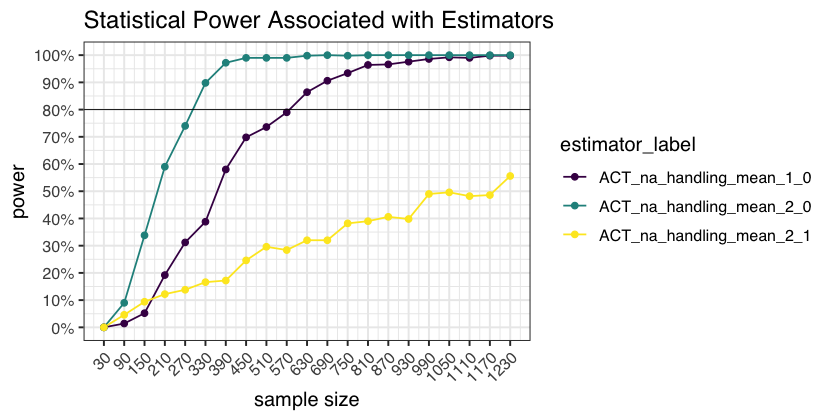

In [6]:
ggplot(power.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

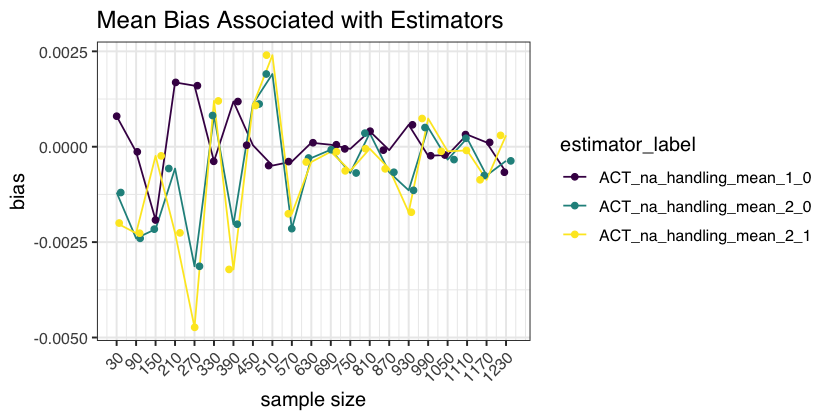

In [7]:
ggplot(power.iterate.df, aes(n, bias, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_jitter(width=20, height=0) +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Bias Associated with Estimators")

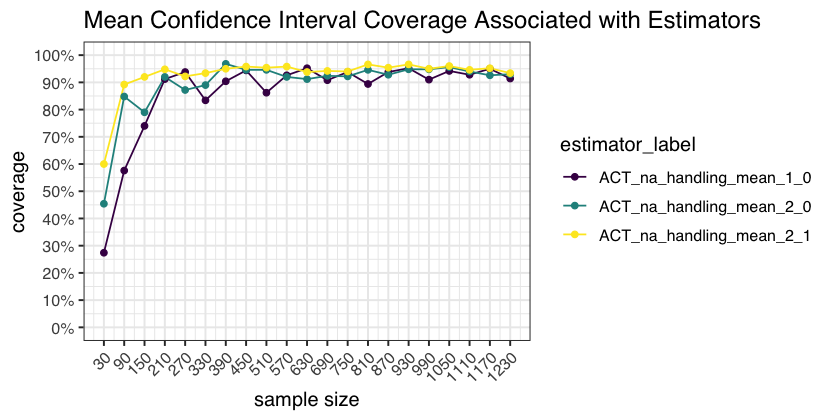

In [8]:
ggplot(power.iterate.df, aes(n, coverage, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Mean Confidence Interval Coverage Associated with Estimators")

Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

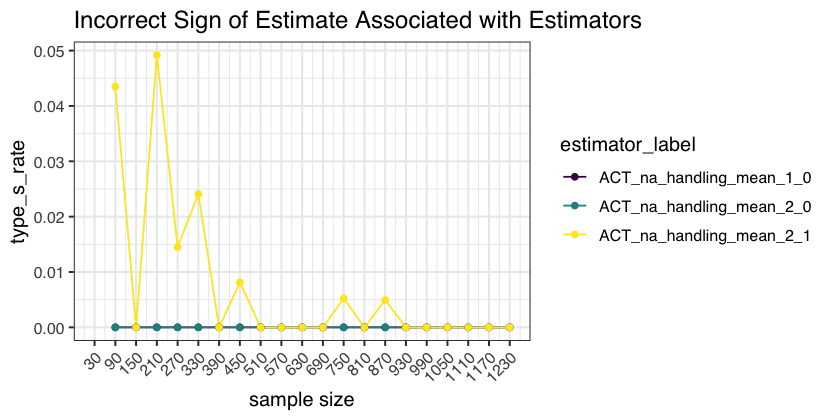

In [9]:
ggplot(power.iterate.df, aes(n, type_s_rate, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_x_continuous(breaks = seq(example.config$n.min,example.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Incorrect Sign of Estimate Associated with Estimators")